In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

inspector = inspect(engine)
# reflect the tables
tables = inspector.get_table_names()
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [6]:
# reflect an existing database into a new model
# reflect the tables

#using automap_base()
Base = automap_base()
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
#tables
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
conn = engine.connect()
query = text("""
        Select MAX(date)
        from measurement
        """)
recent_date_sql = conn.execute(query).fetchall()
recent_date_sql


[('2017-08-23',)]

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [12]:
query = text("""
        Select date, prcp as precipitation
        from measurement
        where date >= '2016-08-23'
        order by date asc
        """)
df_sql = pd.read_sql((query), con=conn)
df_sql

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


In [13]:
# Calculate the date one year from the last date in data set.
date_str = recent_date[0]
date_obj = dt.date.fromisoformat(date_str)
one_year_ago = date_obj - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all() 
#results
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df_sorted = df.sort_values(by='date').reset_index(drop=True)
df_sorted.head()



,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,NaN
2,2016-08-23,1.79
3,2016-08-23,0.05
4,2016-08-23,0.15


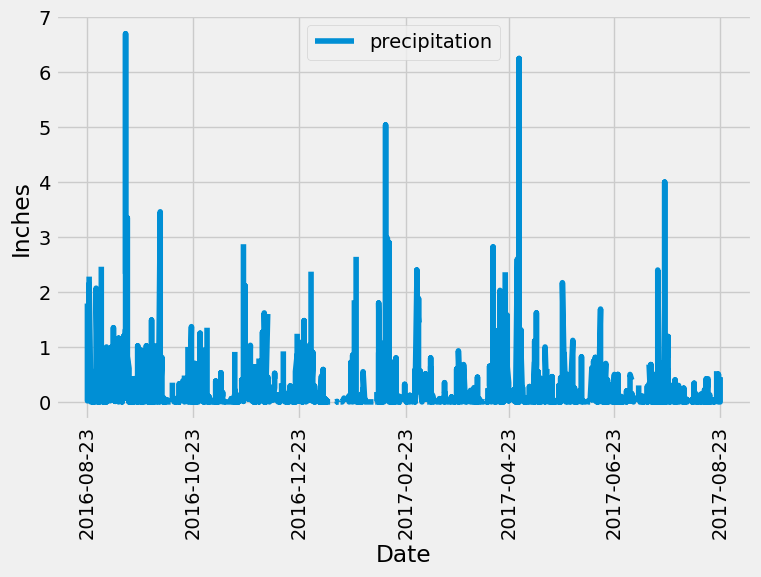

<Figure size 1000x600 with 0 Axes>

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_xticks = ["2016-08-23", "2016-10-23", "2016-12-23", "2017-02-23", "2017-04-23", "2017-06-23", "2017-08-23"]
plt.figure(figsize=(8,5))
plt.plot(df_sorted.date, df_sorted["precipitation"],)
plt.xticks(prcp_xticks, rotation = 90)
plt.legend(["precipitation"], loc=9)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.figure(figsize=(10,6))
plt.show()

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# TA Kourt Bailey suggested as dates are repeating in above dataframe we can do avg precipitation grouping by date

# Perform a query to retrieve the data and precipitation scores
avg_results = session.query(Measurement.date,func.avg(Measurement.prcp)).\
                filter(Measurement.date >= one_year_ago).\
                 group_by(Measurement.date).\
            all() 
avg_results
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_avg = pd.DataFrame(avg_results, columns=['date', 'avg precipitation'])
df_avg.head()
# Sort the dataframe by date
df_avg_sorted = df_avg.sort_values(by='date').reset_index(drop=True)
df_avg_sorted.head()



,date,avg precipitation
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


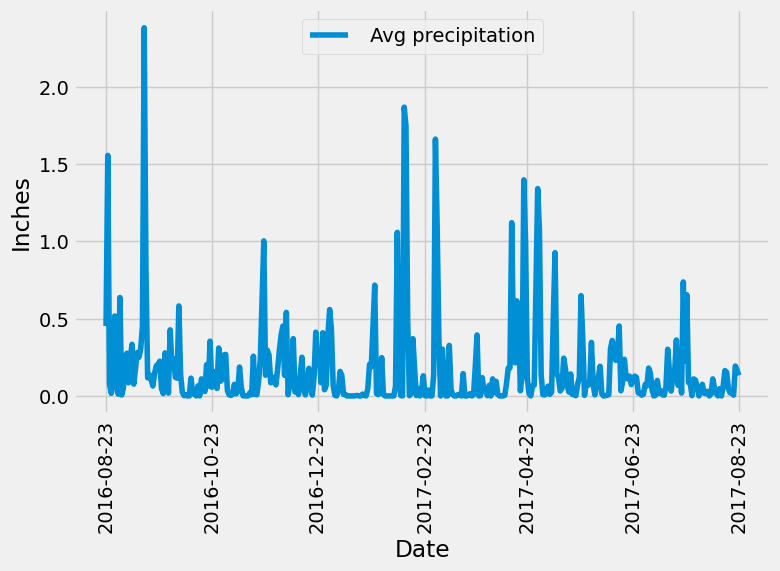

In [17]:
# TA Kourt Bailey suggested as dates are repeating in above dataframe we can do avg precipitation grouping by date
# Use Pandas Plotting with Matplotlib to plot the data
prcp_xticks = ["2016-08-23", "2016-10-23", "2016-12-23", "2017-02-23", "2017-04-23", "2017-06-23","2017-08-23"]
plt.figure(figsize=(8,5))
plt.plot(df_avg_sorted.date, df_avg_sorted["avg precipitation"])
plt.legend([" Avg precipitation"], loc=9)
plt.xticks(prcp_xticks, rotation = 90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_sorted.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
query="""select count(distinct id)
        from station"""
count_station_sql = conn.execute(text(query)).scalar()
count_station_sql

9

In [20]:
session.query(func.count(Station.id.distinct())).scalar()

9

In [21]:
# Design a query to calculate the total number of stations in the dataset
count_station = session.query(Station.id).count()
count_station

9

In [22]:
 # Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query=text(""" select station, count(date)
            from measurement
            group by station
            order by count(date) desc""")
station_counts_sql = conn.execute(query).all()
station_counts_sql


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
 # Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.date)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.date).desc()).\
                        all()
station_counts


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]
most_active_station 


'USC00519281'

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = text("""select min(tobs), max(tobs), avg(tobs)
        from measurement
        where station = 'USC00519281'""")
min_max_avg_sql = conn.execute(query).all()
min_max_avg_sql

[(54.0, 85.0, 71.66378066378067)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_max_avg = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station==most_active_station).\
                all()
min_max_avg

[(54.0, 85.0, 71.66378066378067)]

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = text("""select date, tobs
                from measurement
                where station ='USC00519281' and date >= '2016-08-23' """)
df_tobs_sql = pd.read_sql((query), con=conn)
df_tobs_sql


,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


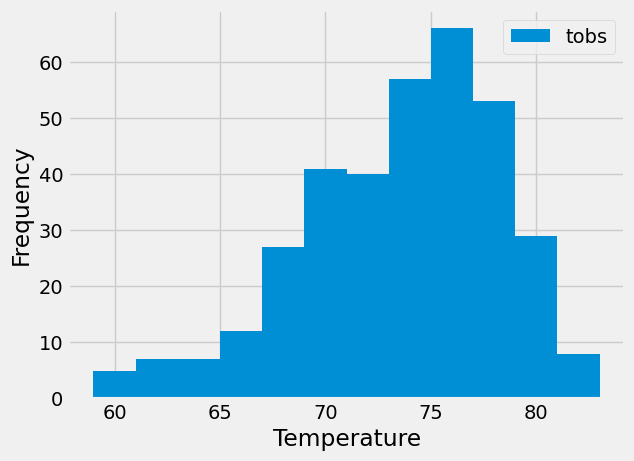

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= one_year_ago).\
            filter(Measurement.station == most_active_station).\
            all() 
df_tobs = pd.DataFrame(results, columns=['Date','tobs'])
df_tobs

plt.hist(df_tobs.tobs, bins=12)
plt.legend(["tobs"])
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [29]:
# Close Session
session.close()